<img style="float:right; max-width:300px" src="imgs/time-series-modelling.jpeg" width="60%" />

# Predikcije vremenske serije
Vremenska serija je kolekcija opservacija $x_t$ uređenih po vremenu. Na osnovu nezavisne promenljive $x$, koja predstavlja vreme, želimo da predvidimo zavisnu promenljivu $y$. Koristimo informacije o prethodnim opservacijama ($y_t$ ne zavisi samo od trenutnog $x_t$, već i od prethodnih opservacija $x_{t-1}$, ...). Predviđamo tačke van poznatog opsega, pa koristimo ekstrapolaciju.

U nastavku se bavimo modelima vremenskih serija sa kojima *predviđamo budućnost* - na osnovu prethodnih opservacija $x$, predviđamo buduće opservacije $y$. Zatim gledamo mere evaluacije, tj. koliko modeli dobro predviđaju.

Za početak, učitavamo neophodne pakete i skup podataka:

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

df = pd.read_csv('data/airline-passengers.csv', sep=',')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Da bismo mogli da evaluiramo model, treba nam validacioni (simulirani test) skup. Kao i do sad, podelićemo podatke na trening i validacioni skup u odnosu $80/20$. Sve dalje transformacije i treniranje modela sprovodimo nad trening skupom, a model evaluiramo na validacionom skupu.

*Napomena: Primeti da ne mešamo podatke kada postavljamo shuffle=True (razmisli zašto).*

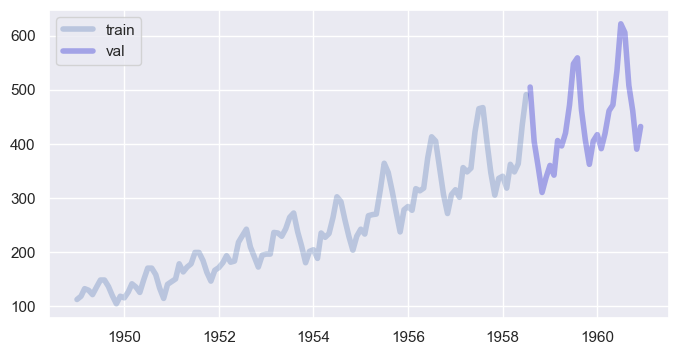

In [7]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

# 1. način - train_test_split() funkcija koja vraća numpy nizove
# x_train, y_train, x_val, y_val = train_test_split(df['Passengers'], df['Month'], train_size=0.8, shuffle=False)

# 2.način - ekvivalentno kao i gore, samo što će nam biti lakše da radimo sa DataFrame objektom
# izdvaja prvih 80% u train_df, a preostalih 20% u val_df
dataset_split = int(len(df['Passengers']) * 0.8)
train_df = df[:dataset_split].copy()
val_df  =  df[dataset_split:].copy()

plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.legend()
plt.show()

Modeli koje razmatramo zahtevaju stacionarnu vremensku seriju. Zato tražimo transformacije koje će rezultovati stacionarnom vremenskom serijom.

In [8]:
# logaritmovanje i 2x diferenciranje nas dovodio do stacionarnosti
train_df['log10(Passengers)'] = np.log10(train_df['Passengers'])
train_df['stationary_data'] = train_df['log10(Passengers)'].diff().diff()

p_value = adfuller(train_df['stationary_data'].dropna())[1]
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')

postoji stacionarnost


Odredili smo koje transformacije nas dovode do stacionarnosti i sačuvali ih u koloni `stationary_data`. Zaključujemo da logaritmovanje i dvostruko diferenciranje dovode do stacionarnih podataka. Ipak, nećemo koristiti kolonu `stationary_data`, već ćemo koristiti kolonu `log10(Passengers)`, a dvostruko diferenciranje prepustićemo paketu `statsmodels`.

## Modeli
U nastavku radimo 4 modela za vremenske serije:

| Model             | Opis         | Formula | Određivanje reda modela | Poziv u statsmodels paketu |
|-------------------|--------------|---------|-------------------------|----------------------------|
| AR (AutoRegressive) autoregresivni| Trenutna vrednost je linearna kombinacija prethodnih $p$ vrednosti. | $$Yar = Y_{t} = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \epsilon_t$$  | Za red AR modela koristimo značajne vrednosti PACF. | `ARIMA(x_train, order=(p, 0, 0)).fit()` |
| MA (Moving Average) model pokretnog proseka| Trenutna vrednost je linearna kombinacija prethodnih $q$ grešaka i neke vrednosti.    | $$Yma = Y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}$$  | Za red MA modela koristimo značajne vrednosti ACF. | `ARIMA(x_train, order=(0, 0, q)).fit()` |
| ARMA (AutoRegressive Moving Average) | Trenutna vrednost je zbir AR i MA modela.   | $$Y_t = Yar + Yma$$  | Za red AR modela koristimo značajne vrednosti PACF, a za red MA modela koristimo značajne vrednosti ACF. | `ARIMA(x_train, order=(p, 0, q)).fit()` |
| ARIMA (AutoRegressive Integrated Moving Average) | Trenutna vrednost je zbir AR i MA modela, uz mogućnost diferenciranja. | $$Y_t' = Yar' + Yma$$ | Za određivanje reda AR i MA modela koristimo značajne vrednosti PACF i ACF nakon diferenciranja serije ako je potrebno. | `ARIMA(x_train, order=(p, d, q)).fit()`|

Poslednja kolona govori o tome kako da pozovemo svaki od modela. Svaki model može se izvesti iz ARIMA modela promenom odgovarajućih parametara. U nastavku prikazujemo proces treniranja i evaluacije nad AR modelom, analogno važi i za ostale modele.

### AR model
Kao što smo videli, nakon logaritmovanja vremenske serije, seriju treba 2x diferencirati. Ovo prepuštamo `statsmodels` paketu menjanjem parametra `d=2` u `order=(p, 2, q)`. Pošto želimo samo AR model, bez MA modela, znamo da je `q=0`, odnosno `order=(p, 2, 0)`. Ostaje nam da odredimo parametar `p` - red AR modela - određujemo preko PACF grafika tako što biramo značajnu vrednost.

*Napomena: ACF i PACF sada analiziramo nad stacionarnim podacima, kako bismo odredili red modela.*

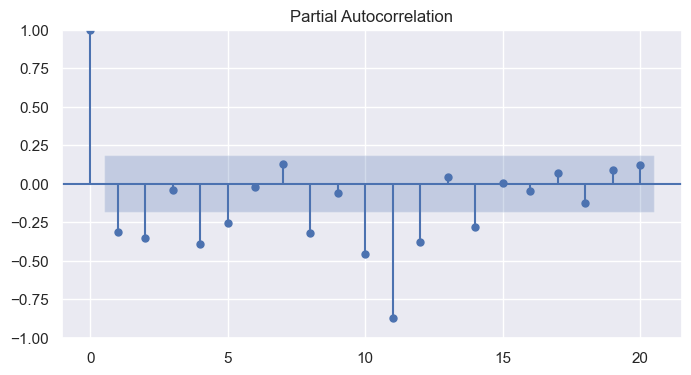

In [9]:
plot_pacf(train_df['stationary_data'].dropna(), lags=20, method='ols')
plt.show()

Sa ACF grafika vidimo da su značajne vrednosti za $p=1,2,4,5,8, 10, 11, 12, 14$.
Ispitujemo poslednjih nekoliko značajnih vrednosti za $p$ (u ovom slučaju bi izabrali $p=14$), ali koristimo domensko znanje da postoji sezonalnost na svakih 12 meseci pa biramo $p=12$.

*Napomena: promena parametra `method` može rezultovati različitim grafikom. Npr. za podrazumevani parametar `method='ywm'` će reći da je treba izabrati $p=13$ za AR model. Treba isprobati i jednu i drugu opciju.*

Znamo da je $p=12$ i $d=2$ pa koristimo `order=(12, 2, 0)` i treniramo AR model:

In [10]:
p, d, q = 12, 2, 0
ar_model = ARIMA(train_df['log10(Passengers)'], order=(p, d, 0)).fit()
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:      log10(Passengers)   No. Observations:                  115
Model:                ARIMA(12, 2, 0)   Log Likelihood                 281.578
Date:                Tue, 26 Dec 2023   AIC                           -537.155
Time:                        11:05:49   BIC                           -501.699
Sample:                    01-01-1949   HQIC                          -522.768
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2541      0.076    -16.553      0.000      -1.403      -1.106
ar.L2         -1.2998      0.090    -14.450      0.000      -1.476      -1.124
ar.L3         -1.2712      0.095    -13.418      0.0

#### Predikcije
Predviđamo pozivom metode `predict(start, end)`, gde `start` predstavlja početni datum, a `end` krajnji datum. Prvo ćemo pogledati kako se predikcije modela izgledaju nad trening podacima.

Pošto smo izabrali $p=12$, to znači da je neophodno da model dobije prethodnih 12 podataka da bi mogao predvideti 13. podatak. Zato kada predviđamo, to radimo od 13. podatka pa nadalje.

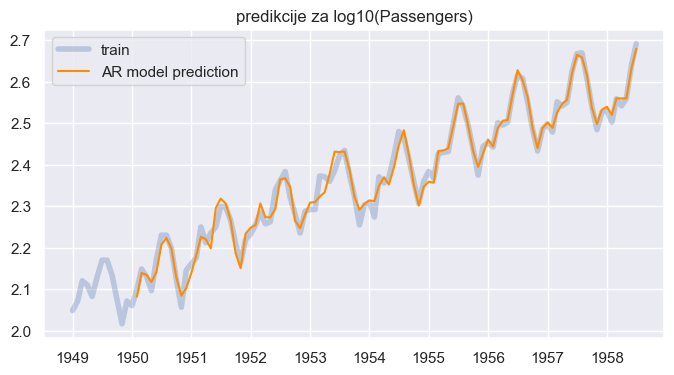

In [12]:
y_train_pred = ar_model.predict(start=train_df.index[p+1], end=train_df.index[-1])

plt.plot(train_df['log10(Passengers)'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(y_train_pred, color='darkorange', label='AR model prediction')
plt.title('predikcije za log10(Passengers)')
plt.legend()
plt.show()

Vidimo da model dobro radi nad trening podacima. Testiramo kako radi nad validacionim podacima:

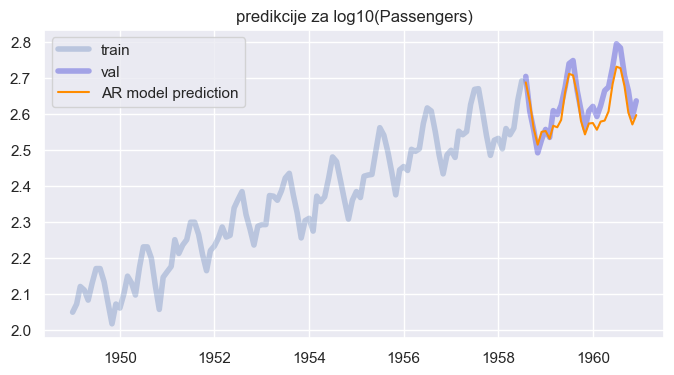

In [15]:
val_df['log10(Passengers)'] = np.log10(val_df['Passengers'])
y_val_pred = ar_model.predict(start=val_df.index[0], end=val_df.index[-1])

plt.plot(train_df['log10(Passengers)'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['log10(Passengers)'], color='mediumblue', linewidth=4, alpha=0.3, label='val')

plt.plot(y_val_pred, color='darkorange', label='AR model prediction')
plt.title('predikcije za log10(Passengers)')
plt.legend()
plt.show()

Trenutno smo prikazali predikcije nad logaritmovanim podacima. Kako prikazati predikcije nad originalnim podacima?

##### Prikaz predikcije na originalnoj vremenskoj seriji
Modelu prosleđujemo logaritmovane podatke, a zatim ih on diferencira i na kraju trenira model (traži parametre modela).
Da bismo dobili originalne vrednosti, neophodno je izvršiti inverzne operacije u obrnutom redosledu. Konkretno, trebamo uraditi dve inverzne operacije od diferenciranja (cumsum operacija) i zatim inverznu operaciju od logaritmovanja (eksponenciranje).
Inverzna operacija od diferenciranja se automatski vrši kada pozovemo metodu `predict()` iz `statsmodels`, pa je na nama samo da eksponenciramo podatke.

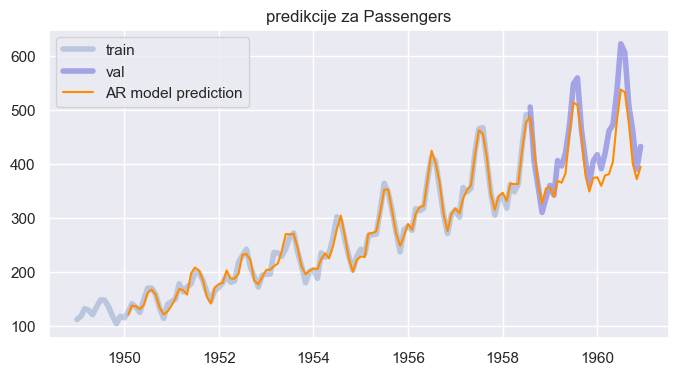

In [8]:
# predict automatski radi inverzne operacije od diferenciranja
y_pred = ar_model.predict(start=train_df.index[p+1], end=val_df.index[-1])
# eksponenciranje
y_pred = np.power(10, y_pred)

plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.plot(y_pred, color='darkorange', label='AR model prediction')
plt.title('predikcije za Passengers')
plt.legend()
plt.show()

### ARIMA model
Kreiramo ARIMA model (kombinacija AR i MA modela), kako bismo mogli uporediti performanse oba modela. Prethodno smo utvrdili da nam za postizanje stacionarnosti treba dvostruko diferenciranje $d=2$, a red AR modela je $p=12$, što rezultuje parametrima `order=(12, 2, q)`. Preostaje da odredimo red MA modela, a tu koristimo informacije sa ACF grafika.

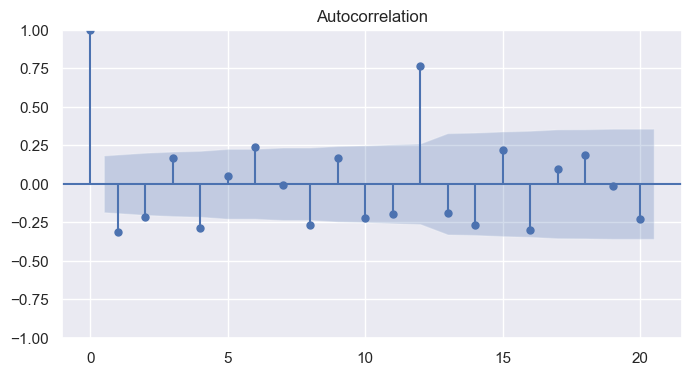

In [9]:
plot_acf(train_df['stationary_data'].dropna(), lags=20)
plt.show()

Na ACF grafiku tražimo značajne $q$ vrednosti posle kojih postoji nagli pad. Vidimo da postoji nagli pad posle $q=2$, pa zaključujemo da pretprošli mesec ima značajan direktan uticaj. Biramo $q=2$.

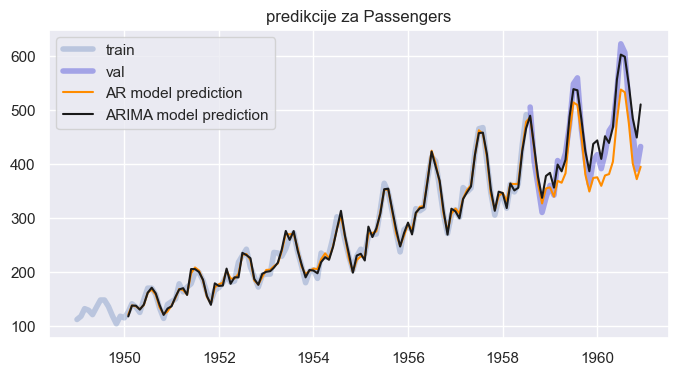

In [34]:
p, d, q = 12, 2, 2
arima_model = ARIMA(train_df['log10(Passengers)'], order=(p, d, q)).fit()

y_pred_arima = arima_model.predict(start=train_df.index[p+1], end=val_df.index[-1])
y_pred_arima = np.power(10, y_pred_arima)

plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.plot(y_pred, color='darkorange', label='AR model prediction')
plt.plot(y_pred_arima, color='k', label='ARIMA model prediction')
plt.title('predikcije za Passengers')
plt.legend()
plt.show()

## Evaluacija
Sa grafika vidimo da se model dobro uklapa u podatke. Finalni korak je da evauliramo modele. Uporedićemo AR model i ARIMA model.

| Metrika | Formula |
|---------|---------|
| MSE (Mean Squared Error) | $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \lvert Y_i - \hat{Y}_i \rvert^2 $ |
| RMSE (Root Mean Squared Error) | $ \text{RMSE} = \sqrt{\text{MSE}} $ |
| MAE (Mean Absolute Error) | $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \lvert Y_i - \hat{Y}_i \rvert $ |
| MAPE (Mean Absolute Percentage Error) | $ \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{\lvert Y_i - \hat{Y}_i \rvert}{\lvert Y_i \rvert} \times 100 \% $ |
| MASE (Mean Absolute Scaled Error) | $ \text{MASE} = \frac{\text{MAE}}{\frac{1}{n-1} \sum_{i=2}^{n} \lvert Y_i - Y_{i-1} \rvert} $ |

Svaka od metrika ima prednosti i mane. Koja je najpogodnija zavisi od problema koji se rešava (detaljnije na predavanjima).

In [35]:
# importujemo neophodne metrike (za vezbu probaj samostalno da ih napises)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mse = mean_squared_error
mae = mean_absolute_error
mape = mean_absolute_percentage_error

actual = val_df['Passengers']
ar_pred = ar_model.predict(start=val_df.index[0], end=val_df.index[-1])
ar_pred = np.power(10, ar_pred) # eksponenciramo jer poredimo sa kolonom 'Passengers' a ne 'log10(Passengers)'
print('AR model evaluacija nad validacionim skupom:')
print(f'{mse(actual, ar_pred)=:.2f}', f'{mae(actual, ar_pred)=:.2f}')

arima_pred = arima_model.predict(start=val_df.index[0], end=val_df.index[-1])
arima_pred = np.power(10, arima_pred) # eksponenciramo jer poredimo sa kolonom 'Passengers' a ne 'log10(Passengers)'
print('\nARIMA model evaluacija nad validacionim skupom:')
print(f'{mse(actual, arima_pred)=:.2f}', f'{mae(actual, arima_pred)=:.2f}')

AR model evaluacija nad validacionim skupom:
mse(actual, ar_pred)=1680.71 mae(actual, ar_pred)=34.45

ARIMA model evaluacija nad validacionim skupom:
mse(actual, arima_pred)=784.01 mae(actual, arima_pred)=23.56


Evaluacija prema trenutnim merama nam govori da je ARIMA model bolji od AR modela, što smo i videli sa grafika.
Trenutni način evaluacije modela meri koliko model dobro predviđa od 1958-07-01 (poslednje poznate vrednosti u trening skupu), pa sve do 1960-12-01 (poslednje poznate vrednosti u validacionom skupu), što je raspon od 29 meseci. Da li nas stvarno zanima broj putnika za tako dalek vremenski period? Uglavnom ne. U većini domena zanima nas samo jedna predikcija unapred. U tom slučaju, potrebna nam je *Walk-Forward* evaluacija.

### *Walk-Forward* evaluacija
Iterativno predviđamo naredni vremenski trenutak, pri čemu u svakoj iteraciji treniramo model proširivanjem trening skupa stvarnom vrednošću (kod nas dobijamo iz validacionog skupa). Ideja je da se nova izmerena vrednost doda u trening skup, kako bismo uvek predviđali samo sledeći vremenski trenutak. Ovakva evaluacija modela najviše odgovara realnosti.

ARIMA walk-forward evaluacija nad validacionim skupom:
mse(actual, wf_pred)=359.51 mae(actual, wf_pred)=14.67


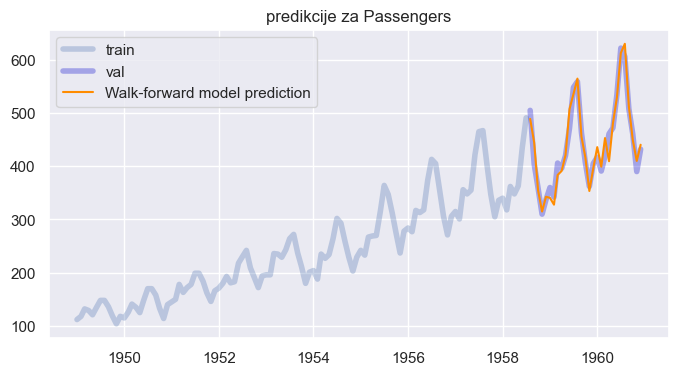

In [13]:
def walk_forward_loop(train_df, val_df, column_name, order=(0, 0, 0)):
    history = train_df[column_name].copy() # trening skup koji prosirujemo stvarnom vrednosti
    wf_pred = pd.Series() # serija predikcija koju iterativno popunjavamo
    
    for i in range(len(val_df)):
        wf_model = ARIMA(history, order=order).fit()
        # sačuvaj predikciju
        y_pred = wf_model.forecast(steps=1)
        wf_pred = pd.concat([wf_pred, y_pred])
        # sačuvaj stvarnu vrednost u trening skup
        true_value = pd.Series(data=val_df.iloc[i][column_name], index=[val_df.index[i]])
        history = pd.concat([history, true_value])
    
    return wf_pred

# evaluiramo
actual = val_df['Passengers']
wf_pred = walk_forward_loop(train_df, val_df, column_name='log10(Passengers)', order=(p, d, q))
wf_pred = np.power(10, wf_pred)
print('ARIMA walk-forward evaluacija nad validacionim skupom:')
print(f'{mse(actual, wf_pred)=:.2f}', f'{mae(actual, wf_pred)=:.2f}')

# crtamo grafik
plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.plot(wf_pred, color='darkorange', label='Walk-forward model prediction')
plt.title('predikcije za Passengers')
plt.legend()
plt.show()

Vidimo koliko je bolji rezultat dobijen na ovaj način jer svaki put predviđamo samo narednu vrednost.

## Zadaci
**TODO 1**: Učitaj vremensku seriju za broj putnika koristeći [data/airline-passengers.csv](data/airline-passengers.csv). Zatim:
1. Podeli vremensku seriju na trening i validacioni skup u odnosu 70:30.
1. Proveri da li su podaci sortirani.
1. Napravi najbolji MA model (model pokretnog proseka) i ispiši koliku RMSE meru model ostvaruje koristeći walk-forward evaluaciju. 
1. Nacrtaj grafik predikcija.
1. Napravi MA model koristeći sve podatke i proceni koliko putnika se očekuje u prvom kvartalu 1961. godine.
1. Napravi ARIMA model (koristeći sve podatke) tako da su mu predikcije za prvi kvartal 1961. godine najbliže MA modelu. Smatrati da red AR modela $p \neq 0$.